In [1]:
import torch 
import torch.nn as nn

# YOLO ARCHITECTURE

<img src="./YOLO_Architecture_from_the_original_paper_.png">

Image Reference: https://www.datacamp.com/blog/yolo-object-detection-explained

The following code is inspired and taken from this repo : https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/YOLO/

## Lets build our model

In [2]:
""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4], # list architecture
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)            # Not used in original implementation!
        self.leakyrelu = nn.LeakyReLU(0.1) 
        
    def forward(self,x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))        

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fc(**kwargs)
    
    def forward(self,x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))
    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(in_channels, out_channels = x[1], kernel_size=x[0], stride=x[2], padding=x[3],)]
                in_channels = x[1]

            if type(x) == str:
                layers += [
                    nn.MaxPool2d(kernel_size=2, stride=2)]

            if type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(in_channels, out_channels = conv1[1], kernel_size= conv1[0], stride=conv1[2], padding=conv1[3],)]
                    layers += [
                        CNNBlock(conv1[1], out_channels = conv2[1], kernel_size= conv2[0], stride=conv2[2], padding=conv2[3],)]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)
    
    def _create_fc(self, split_size, num_boxes, num_classes):
        S,B,C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024*S*S , 4096),
            nn.Dropout(0.5),                         # not implemented in paper
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S*S*(C + B*5)),           # C+5*B = 30
        )

In [5]:
# Test our model

model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
print(model)

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [6]:
x = torch.randn(2, 3, 448, 448)
print(model(x).shape)                      # 7*7*30 = 1470

torch.Size([2, 1470])


## Lets build our Loss Function

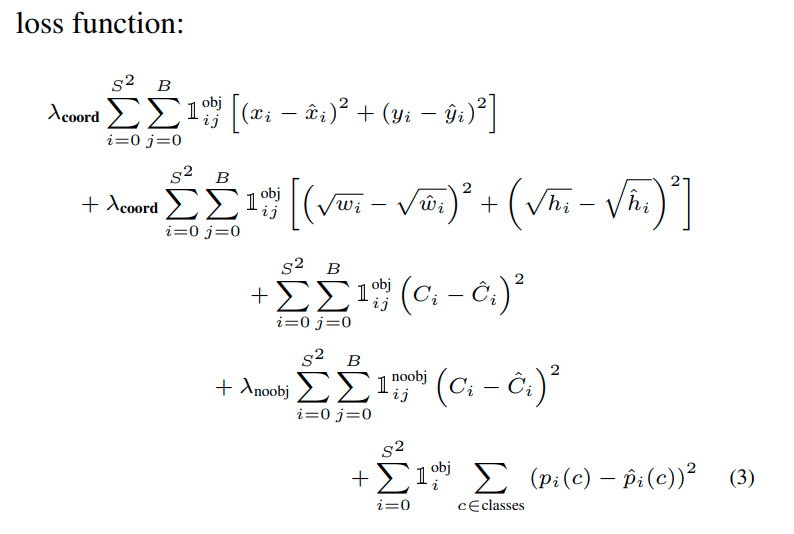

In [7]:
from dataset import VOCDataset
from utils import intersection_over_union

In [8]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [9]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)

In [10]:
seed = 123
torch.manual_seed(seed)

In [18]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "VOC/images"
LABEL_DIR = "VOC/labels"

In [19]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

In [20]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [21]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "VOC/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "VOC/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)

In [22]:
main()

Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=564]    

Mean loss was 885.2814331054688


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=527]

Mean loss was 562.1545155843099


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=462]

Mean loss was 519.4467112223307


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=401]

Mean loss was 432.32166544596356


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=367]

Mean loss was 365.7016143798828


Train mAP: 5.482455526362173e-05


100%|██████████| 6/6 [00:01<00:00,  4.01it/s, loss=240]

Mean loss was 316.95921579996747


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=453]

Mean loss was 297.69128163655597


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=325]

Mean loss was 294.9368413289388


Train mAP: 0.0


100%|██████████| 6/6 [00:01<00:00,  4.45it/s, loss=306]

Mean loss was 265.4212290445964


Train mAP: 0.012499990873038769


100%|██████████| 6/6 [00:01<00:00,  4.42it/s, loss=234]

Mean loss was 250.16790262858072


Train mAP: 0.020503168925642967


100%|██████████| 6/6 [00:01<00:00,  4.38it/s, loss=230]

Mean loss was 237.43973286946616


Train mAP: 0.04116075113415718


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=251]

Mean loss was 215.46983337402344


Train mAP: 0.1420946717262268


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=176]

Mean loss was 215.65197245279947


Train mAP: 0.16195669770240784


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=185]

Mean loss was 206.90214029947916


Train mAP: 0.2551320195198059


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=222]

Mean loss was 190.23397827148438


Train mAP: 0.24863648414611816


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=231]

Mean loss was 196.30463409423828


Train mAP: 0.2384750097990036


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=180]

Mean loss was 180.1831029256185


Train mAP: 0.33982592821121216


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=171]

Mean loss was 179.43449910481772


Train mAP: 0.3620014190673828


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=213]

Mean loss was 173.69558334350586


Train mAP: 0.40978360176086426


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=156]

Mean loss was 167.6481145222982


Train mAP: 0.3957064747810364


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=195]

Mean loss was 150.65997823079428


Train mAP: 0.4354154169559479


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=139]

Mean loss was 154.77375030517578


Train mAP: 0.4752192497253418


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=160]

Mean loss was 145.48929595947266


Train mAP: 0.3954211175441742


100%|██████████| 6/6 [00:01<00:00,  3.58it/s, loss=125]

Mean loss was 145.0035743713379


Train mAP: 0.5488480925559998


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=159]

Mean loss was 137.60285568237305


Train mAP: 0.5751768350601196


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=120]

Mean loss was 141.08063761393228


Train mAP: 0.5814940929412842


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=129]

Mean loss was 139.4405632019043


Train mAP: 0.6547020673751831


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=145]

Mean loss was 128.57042185465494


Train mAP: 0.7082592248916626


100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=105]

Mean loss was 132.01934051513672


Train mAP: 0.7091138362884521


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=97.7]

Mean loss was 127.23893356323242


Train mAP: 0.754813551902771


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=145] 

Mean loss was 124.45923105875652


Train mAP: 0.7949205040931702


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=125] 

Mean loss was 118.89821370442708


Train mAP: 0.8210332989692688


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=153]

Mean loss was 123.95787684122722


Train mAP: 0.8116132616996765


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=120]

Mean loss was 112.8554458618164


Train mAP: 0.8083379864692688


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=88.3]

Mean loss was 110.23233286539714


Train mAP: 0.7859448194503784


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=138] 

Mean loss was 114.10057830810547


Train mAP: 0.8120104074478149


100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=78.3]

Mean loss was 112.34318161010742


Train mAP: 0.8622139096260071


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=103] 

Mean loss was 113.58818181355794


Train mAP: 0.8103175163269043


100%|██████████| 6/6 [00:01<00:00,  4.39it/s, loss=100]

Mean loss was 108.44141133626302


Train mAP: 0.8444247245788574


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=85.5]

Mean loss was 102.33815892537434


Train mAP: 0.8530204892158508


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=156] 

Mean loss was 111.3296127319336


Train mAP: 0.8797546625137329


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=103] 

Mean loss was 105.53766759236653


Train mAP: 0.8917311429977417


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=102] 

Mean loss was 106.27684275309245


Train mAP: 0.9051701426506042


100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=104] 

Mean loss was 100.26737467447917


Train mAP: 0.8891180753707886


100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=88.8]

Mean loss was 93.7365239461263


Train mAP: 0.8429139852523804


100%|██████████| 6/6 [00:01<00:00,  4.38it/s, loss=76]  

Mean loss was 93.23060862223308


Train mAP: 0.8532246351242065


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=90.8]

Mean loss was 96.9454116821289


Train mAP: 0.9071140289306641


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=105] 

Mean loss was 92.28032684326172


Train mAP: 0.8981553316116333


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=95.3]

Mean loss was 97.01684315999348


Train mAP: 0.8874239921569824


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=81.9]

Mean loss was 96.25282923380534


Train mAP: 0.88801109790802


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=74.7]

Mean loss was 93.32514063517253


Train mAP: 0.9132660627365112


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=117] 

Mean loss was 98.09275690714519


Train mAP: 0.9220342636108398


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=104] 

Mean loss was 92.15823364257812


Train mAP: 0.8841513395309448


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=72.8]

Mean loss was 92.54303868611653


Train mAP: 0.9226473569869995


100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=108] 

Mean loss was 88.75318845113118


Train mAP: 0.9079130291938782


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=91]  

Mean loss was 87.20116678873698


Train mAP: 0.8914536237716675


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=91.1]

Mean loss was 86.59188334147136


Train mAP: 0.8560818433761597


100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=96.1]

Mean loss was 88.91118876139323


Train mAP: 0.8927227258682251


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=64.1]

Mean loss was 82.22903442382812


Train mAP: 0.9493470191955566


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=97.9]

Mean loss was 84.42866516113281


Train mAP: 0.9611718058586121


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=104] 

Mean loss was 87.13239924112956


Train mAP: 0.9518488645553589


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=102] 

Mean loss was 84.21863174438477


Train mAP: 0.9040752053260803


100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=95]  

Mean loss was 82.05931282043457


Train mAP: 0.9053357243537903


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=103] 

Mean loss was 81.21713256835938


Train mAP: 0.8788679242134094


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=62.7]

Mean loss was 78.78776105244954


Train mAP: 0.901725172996521


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=100] 

Mean loss was 84.9900499979655


Train mAP: 0.907906711101532


100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=89.8]

Mean loss was 91.8091557820638


Train mAP: 0.8810375928878784


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=68.3]

Mean loss was 86.91024271647136


Train mAP: 0.8712056875228882


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=64.8]

Mean loss was 83.62220064798991


Train mAP: 0.9267951846122742


100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=88.8]

Mean loss was 79.00202814737956


Train mAP: 0.9618159532546997


100%|██████████| 6/6 [00:01<00:00,  4.45it/s, loss=54.3]

Mean loss was 80.7984676361084


Train mAP: 0.9242144823074341


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=76.1]

Mean loss was 81.1649538675944


Train mAP: 0.912116527557373


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=104] 

Mean loss was 77.99308395385742


Train mAP: 0.9315662384033203


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=61.7]

Mean loss was 74.60450172424316


Train mAP: 0.9227520823478699


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=65]  

Mean loss was 76.03028615315755


Train mAP: 0.9356877207756042


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=82.7]

Mean loss was 74.31961504618327


Train mAP: 0.9561840891838074


100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=69.3]

Mean loss was 72.62866910298665


Train mAP: 0.9472616910934448


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=69.5]

Mean loss was 75.3923568725586


Train mAP: 0.9450749158859253


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=83.8]

Mean loss was 74.7387040456136


Train mAP: 0.9118199348449707


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=68.8]

Mean loss was 71.83955764770508


Train mAP: 0.9180717468261719


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=77.8]

Mean loss was 69.21357536315918


Train mAP: 0.9222647547721863


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=75.7]

Mean loss was 69.4163335164388


Train mAP: 0.9130245447158813


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=62.4]

Mean loss was 72.50340970357259


Train mAP: 0.9279149174690247


100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=84.6]

Mean loss was 71.39870262145996


Train mAP: 0.9221380352973938


100%|██████████| 6/6 [00:01<00:00,  4.35it/s, loss=85.9]

Mean loss was 68.40966860453288


Train mAP: 0.9481040239334106


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=58.3]

Mean loss was 70.28055127461751


Train mAP: 0.9474948644638062


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=75.9]

Mean loss was 70.03675333658855


Train mAP: 0.9340143203735352


100%|██████████| 6/6 [00:01<00:00,  4.06it/s, loss=76.5]

Mean loss was 69.61413192749023


Train mAP: 0.9306942820549011


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=49.6]

Mean loss was 66.85208257039388


Train mAP: 0.9218392372131348


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=68]  

Mean loss was 67.62475967407227


Train mAP: 0.9520017504692078


100%|██████████| 6/6 [00:01<00:00,  4.37it/s, loss=51.4]

Mean loss was 68.33474349975586


Train mAP: 0.933956503868103


100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=51.1]

Mean loss was 66.41828854878743


Train mAP: 0.9673686623573303


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=66.6]

Mean loss was 66.43057823181152


Train mAP: 0.9409533739089966


100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=73.6]

Mean loss was 65.22399838765462


Train mAP: 0.9239547848701477


100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=61.4]

Mean loss was 65.06125768025716


Train mAP: 0.9327875375747681


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=56.6]

Mean loss was 64.80571619669597


Train mAP: 0.9186914563179016


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=71.3]

Mean loss was 64.66211573282878


Train mAP: 0.9304476976394653


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=64.4]

Mean loss was 64.13075892130534


Train mAP: 0.9087198376655579


100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=57.1]

Mean loss was 64.88211059570312


Train mAP: 0.9068088531494141


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=59.6]

Mean loss was 63.23297437032064


Train mAP: 0.9319012761116028


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=59.4]

Mean loss was 65.10934448242188


Train mAP: 0.9604665637016296


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=65.4]

Mean loss was 64.45070266723633


Train mAP: 0.9519159197807312


100%|██████████| 6/6 [00:01<00:00,  4.35it/s, loss=38.8]

Mean loss was 60.05673853556315


Train mAP: 0.9533023834228516


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=47.5]

Mean loss was 65.2309118906657


Train mAP: 0.9596474766731262


100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=47.3]

Mean loss was 61.09259923299154


Train mAP: 0.9211214184761047


100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=66.1]

Mean loss was 56.958705266316734


Train mAP: 0.9284756779670715


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=60.9]

Mean loss was 60.1730047861735


Train mAP: 0.9258527755737305


100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=71]  

Mean loss was 61.01570383707682


Train mAP: 0.914921760559082


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=79.6]

Mean loss was 58.56946627298991


Train mAP: 0.9277175068855286


100%|██████████| 6/6 [00:01<00:00,  4.03it/s, loss=54.8]

Mean loss was 61.06761805216471


Train mAP: 0.9344895482063293


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=55.3]

Mean loss was 61.397120793660484


Train mAP: 0.8980317115783691


100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=64.6]

Mean loss was 62.73649024963379


Train mAP: 0.9218913316726685


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=46.8]

Mean loss was 60.365269343058266


Train mAP: 0.9442447423934937


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=51.6]

Mean loss was 59.27235094706217


Train mAP: 0.9192198514938354


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=77.7]

Mean loss was 58.198219299316406


Train mAP: 0.9055274724960327


100%|██████████| 6/6 [00:01<00:00,  4.01it/s, loss=49.4]

Mean loss was 59.42174212137858


Train mAP: 0.9207145571708679


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=56.3]

Mean loss was 56.93938128153483


Train mAP: 0.9198993444442749


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=63.2]

Mean loss was 59.36729431152344


Train mAP: 0.9306071400642395


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=37.4]

Mean loss was 58.84450340270996


Train mAP: 0.928264319896698


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=73.9]

Mean loss was 56.899929682413735


Train mAP: 0.9342379570007324


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=55]  

Mean loss was 57.13975270589193


Train mAP: 0.9640926122665405


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=58.7]

Mean loss was 58.05712445576986


Train mAP: 0.9318145513534546


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=41.6]

Mean loss was 57.985907872517906


Train mAP: 0.9482425451278687


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=63.4]

Mean loss was 55.64274915059408


Train mAP: 0.9080548286437988


100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=56.5]

Mean loss was 57.14492416381836


Train mAP: 0.9323819875717163


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=56.6]

Mean loss was 54.556435902913414


Train mAP: 0.916695237159729


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=68.2]

Mean loss was 55.52660242716471


Train mAP: 0.9269217252731323


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=46.1]

Mean loss was 53.5003662109375


Train mAP: 0.9394536018371582


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=53.6]

Mean loss was 53.31214586893717


Train mAP: 0.9203255772590637


100%|██████████| 6/6 [00:01<00:00,  4.10it/s, loss=46.3]

Mean loss was 51.661694844563804


Train mAP: 0.9321891665458679


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=62.6]

Mean loss was 54.21197001139323


Train mAP: 0.9157811403274536


100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=53.9]

Mean loss was 54.27565383911133


Train mAP: 0.889642596244812


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=59.1]

Mean loss was 55.141340255737305


Train mAP: 0.9539071917533875


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=54.5]

Mean loss was 54.242218017578125


Train mAP: 0.9280465245246887


100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=49.7]

Mean loss was 52.25700759887695


Train mAP: 0.9077001810073853


100%|██████████| 6/6 [00:01<00:00,  3.81it/s, loss=39.6]

Mean loss was 53.524383544921875


Train mAP: 0.9323671460151672


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=55.7]

Mean loss was 53.03047116597494


Train mAP: 0.9136136174201965


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=43.2]

Mean loss was 53.32223892211914


Train mAP: 0.9154017567634583


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=50.5]

Mean loss was 52.65090878804525


Train mAP: 0.9325695037841797


100%|██████████| 6/6 [00:01<00:00,  4.20it/s, loss=45.7]

Mean loss was 51.509656270345054


Train mAP: 0.9243171811103821


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=71]  

Mean loss was 49.723057428995766


Train mAP: 0.9479648470878601


100%|██████████| 6/6 [00:01<00:00,  4.40it/s, loss=78.3]

Mean loss was 51.97677739461263


Train mAP: 0.9311381578445435


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=49.6]

Mean loss was 53.62221654256185


Train mAP: 0.9263408184051514


100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=45.9]

Mean loss was 50.797796885172524


Train mAP: 0.9526309967041016


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=45.3]

Mean loss was 50.79733149210612


Train mAP: 0.961650550365448


100%|██████████| 6/6 [00:01<00:00,  4.38it/s, loss=50.2]

Mean loss was 52.11620585123698


Train mAP: 0.9641684293746948


100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=50.3]

Mean loss was 50.82769966125488


Train mAP: 0.9666920900344849


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=77.5]

Mean loss was 50.979204177856445


Train mAP: 0.968333899974823


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=43]  

Mean loss was 50.83916473388672


Train mAP: 0.9605145454406738


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=41.4]

Mean loss was 48.59200223286947


Train mAP: 0.9112783670425415


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=49.5]

Mean loss was 49.13756815592448


Train mAP: 0.9172828793525696


100%|██████████| 6/6 [00:01<00:00,  4.08it/s, loss=34.4]

Mean loss was 50.00389607747396


Train mAP: 0.9314360618591309


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=36.4]

Mean loss was 47.18029340108236


Train mAP: 0.9411641359329224


100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=53.9]

Mean loss was 49.105217615763344


Train mAP: 0.9226056337356567


100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=41.3]

Mean loss was 47.65082550048828


Train mAP: 0.9490998983383179


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=39.5]

Mean loss was 47.912879943847656


Train mAP: 0.9610686302185059


100%|██████████| 6/6 [00:01<00:00,  4.26it/s, loss=49.8]

Mean loss was 47.272055308024086


Train mAP: 0.960834801197052


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=32.2]

Mean loss was 45.94952964782715


Train mAP: 0.9511817693710327


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=58.2]

Mean loss was 46.1232074101766


Train mAP: 0.9321707487106323


100%|██████████| 6/6 [00:01<00:00,  4.40it/s, loss=50.1]

Mean loss was 46.1841786702474


Train mAP: 0.9522455334663391


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=59.3]

Mean loss was 48.331617991129555


Train mAP: 0.9491885304450989


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=49.7]

Mean loss was 50.27538871765137


Train mAP: 0.9438979029655457


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=45.6]

Mean loss was 48.427033106486


Train mAP: 0.949586033821106


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=62.2]

Mean loss was 47.53772862752279


Train mAP: 0.9289085865020752


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=42.2]

Mean loss was 48.70187950134277


Train mAP: 0.94050532579422


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=39.3]

Mean loss was 46.94207191467285


Train mAP: 0.9359809756278992


100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=39.3]

Mean loss was 47.284939448038735


Train mAP: 0.9563612937927246


100%|██████████| 6/6 [00:01<00:00,  4.12it/s, loss=46.2]

Mean loss was 47.41912333170573


Train mAP: 0.9190729260444641


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=56.7]

Mean loss was 46.46390469868978


Train mAP: 0.9291852116584778


100%|██████████| 6/6 [00:01<00:00,  4.09it/s, loss=41.1]

Mean loss was 45.14647229512533


Train mAP: 0.9439929127693176


100%|██████████| 6/6 [00:01<00:00,  4.07it/s, loss=40.6]

Mean loss was 46.29296366373698


Train mAP: 0.9502238035202026


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=58.5]

Mean loss was 51.738946278889976


Train mAP: 0.9522838592529297


100%|██████████| 6/6 [00:01<00:00,  4.23it/s, loss=37.9]

Mean loss was 48.06575393676758


Train mAP: 0.9736410975456238


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=50.1]

Mean loss was 47.09314155578613


Train mAP: 0.9859491586685181


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=54.7]

Mean loss was 47.82539431254069


Train mAP: 0.961308479309082


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=37.2]

Mean loss was 45.149950663248696


Train mAP: 0.9221234321594238


100%|██████████| 6/6 [00:01<00:00,  4.42it/s, loss=37.1]

Mean loss was 44.551413218180336


Train mAP: 0.9410350918769836


100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=48.3]

Mean loss was 45.14580726623535


Train mAP: 0.9634534120559692


100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=32.7]

Mean loss was 43.490443547566734


Train mAP: 0.9234784245491028


100%|██████████| 6/6 [00:01<00:00,  4.30it/s, loss=50.5]

Mean loss was 44.75061225891113


Train mAP: 0.954981803894043


100%|██████████| 6/6 [00:01<00:00,  4.36it/s, loss=59.4]

Mean loss was 44.28584671020508


Train mAP: 0.9715051651000977


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=40.7]

Mean loss was 43.80763181050619


Train mAP: 0.9361990690231323


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=38.3]

Mean loss was 42.18118031819662


Train mAP: 0.9348027110099792


100%|██████████| 6/6 [00:01<00:00,  4.28it/s, loss=36.5]

Mean loss was 43.38684908548991


Train mAP: 0.924846351146698


100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=42.9]

Mean loss was 42.16328811645508


Train mAP: 0.9091218113899231


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=29.7]

Mean loss was 44.3110294342041


Train mAP: 0.9311805963516235


100%|██████████| 6/6 [00:01<00:00,  4.34it/s, loss=37.2]

Mean loss was 43.897043228149414


Train mAP: 0.9255126714706421


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=46.4]

Mean loss was 43.59880574544271


Train mAP: 0.9476422071456909


100%|██████████| 6/6 [00:01<00:00,  4.42it/s, loss=51.6]

Mean loss was 40.32648754119873


Train mAP: 0.9601042866706848


100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=51.3]

Mean loss was 41.049815813700356


Train mAP: 0.9570022821426392


100%|██████████| 6/6 [00:01<00:00,  4.25it/s, loss=52.1]

Mean loss was 43.178001403808594


Train mAP: 0.937712550163269


100%|██████████| 6/6 [00:01<00:00,  4.04it/s, loss=37.9]

Mean loss was 42.56217257181803


Train mAP: 0.9399426579475403


100%|██████████| 6/6 [00:01<00:00,  4.24it/s, loss=49.1]

Mean loss was 39.326172510782875


Train mAP: 0.940346896648407


100%|██████████| 6/6 [00:01<00:00,  4.14it/s, loss=25.4]

Mean loss was 39.399006843566895


Train mAP: 0.9380990862846375


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=42.6]

Mean loss was 35.91954644521078


Train mAP: 0.9530566930770874


100%|██████████| 6/6 [00:01<00:00,  4.31it/s, loss=52.6]

Mean loss was 40.15312830607096


Train mAP: 0.9413356781005859


100%|██████████| 6/6 [00:01<00:00,  4.09it/s, loss=42.4]

Mean loss was 41.7552490234375


Train mAP: 0.9366342425346375


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=40.6]

Mean loss was 40.67395528157552


Train mAP: 0.9550834894180298


100%|██████████| 6/6 [00:01<00:00,  4.18it/s, loss=48.5]

Mean loss was 39.66522789001465


Train mAP: 0.9872850179672241


100%|██████████| 6/6 [00:01<00:00,  4.33it/s, loss=43.3]

Mean loss was 42.99220085144043


Train mAP: 0.9800322651863098


100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=36.6]

Mean loss was 40.969841639200844


Train mAP: 0.9546253085136414


100%|██████████| 6/6 [00:01<00:00,  4.22it/s, loss=37.5]

Mean loss was 41.38327662150065


Train mAP: 0.9381486177444458


100%|██████████| 6/6 [00:01<00:00,  4.32it/s, loss=34.9]

Mean loss was 40.99381065368652


Train mAP: 0.9295805096626282


100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=33.2]

Mean loss was 43.364182790120445


Train mAP: 0.9442575573921204


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=29.6]

Mean loss was 38.13788986206055


Train mAP: 0.9337767362594604


100%|██████████| 6/6 [00:01<00:00,  4.16it/s, loss=37.7]

Mean loss was 37.54739634195963


Train mAP: 0.925932765007019


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=27.8]

Mean loss was 38.36260255177816


Train mAP: 0.9523932337760925


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=37.7]

Mean loss was 39.59530512491862


Train mAP: 0.9467295408248901


100%|██████████| 6/6 [00:01<00:00,  4.19it/s, loss=28.4]

Mean loss was 36.9246301651001


Train mAP: 0.9363855123519897


100%|██████████| 6/6 [00:01<00:00,  4.29it/s, loss=34.3]

Mean loss was 38.37394936879476


Train mAP: 0.9475606083869934


100%|██████████| 6/6 [00:01<00:00,  4.17it/s, loss=38.2]

Mean loss was 36.48623116811117


Train mAP: 0.9329808354377747


100%|██████████| 6/6 [00:01<00:00,  4.21it/s, loss=31.2]

Mean loss was 39.349358558654785


Train mAP: 0.9513696432113647


100%|██████████| 6/6 [00:01<00:00,  4.03it/s, loss=37.5]

Mean loss was 38.860312143961586


Train mAP: 0.9585683941841125


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=58.9]

Mean loss was 37.6239595413208


Train mAP: 0.9546001553535461


100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=38.5]

Mean loss was 38.09315490722656


Train mAP: 0.9556909799575806


100%|██████████| 6/6 [00:01<00:00,  4.13it/s, loss=31.3]

Mean loss was 39.60517374674479


Train mAP: 0.9525115489959717


100%|██████████| 6/6 [00:01<00:00,  4.11it/s, loss=45.1]

Mean loss was 38.71842130025228


Train mAP: 0.9311442375183105


100%|██████████| 6/6 [00:01<00:00,  4.27it/s, loss=51.3]

Mean loss was 36.037977854410805


Train mAP: 0.9446112513542175


100%|██████████| 6/6 [00:01<00:00,  4.15it/s, loss=48.9]

Mean loss was 37.953359603881836


Train mAP: 0.9477297067642212


100%|██████████| 6/6 [00:01<00:00,  4.06it/s, loss=32]  

Mean loss was 38.68390051523844


Train mAP: 0.9543886184692383


100%|██████████| 6/6 [00:01<00:00,  4.05it/s, loss=27.6]

Mean loss was 37.222792307535805


KeyboardInterrupt: 

In [23]:
model.eval()


Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [29]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

results = []

test_dataset = VOCDataset(
    "VOC/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

with torch.no_grad():  # disables gradient computation
    for imgs, filenames in test_loader:
        imgs = imgs.to(DEVICE)
        model.to(DEVICE)
        predictions = model(imgs)  # output shape: (batch_size, S, S, B*5 + C)
        # You will need to decode these predictions to bounding boxes, class, and confidence

        # Example: store raw predictions with filename
        for i in range(len(filenames)):
            results.append({
                "filename": filenames[i],
                "prediction": predictions[i].cpu()
            })


In [48]:
def decode_yolo_output(prediction, S=7, B=2, C=20, conf_threshold=0.001):
    """
    prediction: (S, S, B*5 + C)
    Returns a list of boxes in [x1, y1, x2, y2, class, confidence]
    """
    boxes = []
    prediction.cpu()
    cell_size = 1 / S
    for i in range(S):
        for j in range(S):
            cell = prediction[i, j]
            class_probs = cell[B*5:]
            for b in range(B):
                box = cell[b*5:b*5+5]
                conf = box[4]
                if conf > conf_threshold:
                    # Convert relative box to image coordinates
                    x, y, w, h = box[0], box[1], box[2], box[3]
                    x_center = (j + x) * cell_size
                    y_center = (i + y) * cell_size
                    x1 = x_center - w/2
                    y1 = y_center - h/2
                    x2 = x_center + w/2
                    y2 = y_center + h/2
                    class_id = torch.argmax(class_probs)
                    boxes.append([x1, y1, x2, y2, class_id.item(), conf.item()])
    return boxes


In [49]:
import torchvision

def apply_nms(boxes, iou_threshold=0.5):
    if len(boxes) == 0:
        return []
    boxes_tensor = torch.tensor([b[:4] for b in boxes])
    scores = torch.tensor([b[5] for b in boxes])
    class_ids = torch.tensor([b[4] for b in boxes])

    keep = torchvision.ops.nms(boxes_tensor, scores, iou_threshold)
    return [boxes[i] for i in keep]


In [50]:
import matplotlib.pyplot as plt
import torch

def show_image(img_tensor):
    # img_tensor shape: [C, H, W]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  # [H, W, C]
    plt.imshow(img)
    plt.axis('off')


In [63]:
import matplotlib.patches as patches

def plot_boxes(img_tensor, boxes, class_names=None):
    """
    img_tensor: [C,H,W] image tensor (can be on GPU)
    boxes: list of [x1, y1, x2, y2, class_id, conf]
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1)
    # Move to CPU and convert to numpy
    img = img_tensor.detach().cpu().permute(1,2,0).numpy()
    ax.imshow(img)

    H, W = img.shape[:2]
    for box in boxes:
        x1, y1, x2, y2, class_id, conf = box
        # Convert to Python floats
        x1 = float(x1)
        y1 = float(y1)
        x2 = float(x2)
        y2 = float(y2)
        class_id = int(class_id)
        conf = float(conf)
    
        rect = patches.Rectangle(
            (x1*W, y1*H), (x2-x1)*W, (y2-y1)*H,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        label = f"{class_names[class_id] if class_names else class_id} {conf:.2f}"
        ax.text(x1*W, y1*H-5, label, color='yellow', fontsize=10, backgroundcolor='black')


    plt.axis('off')
    plt.show()


torch.Size([16, 7, 7, 30])


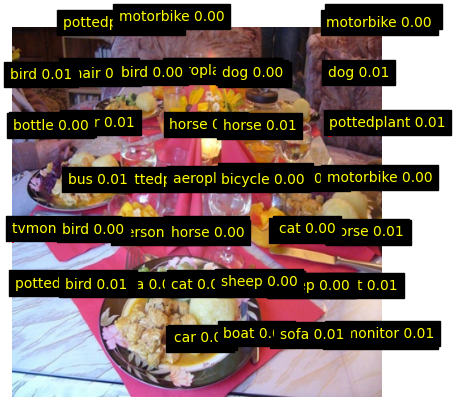

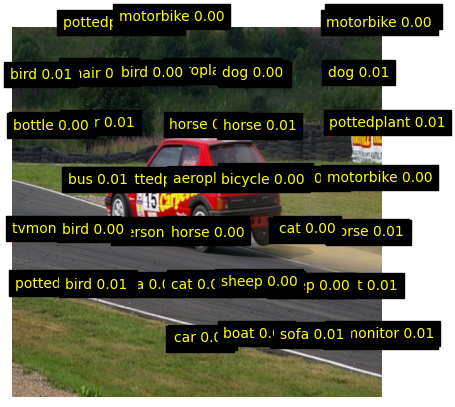

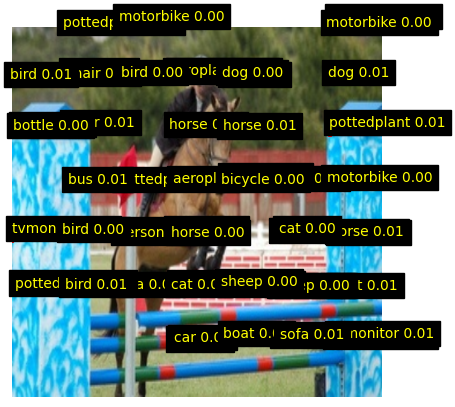

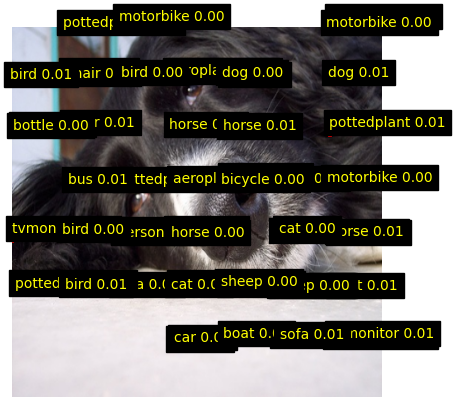

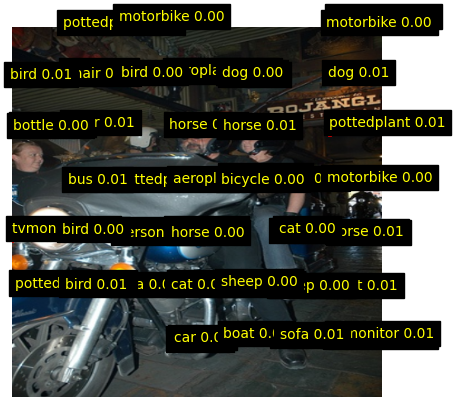

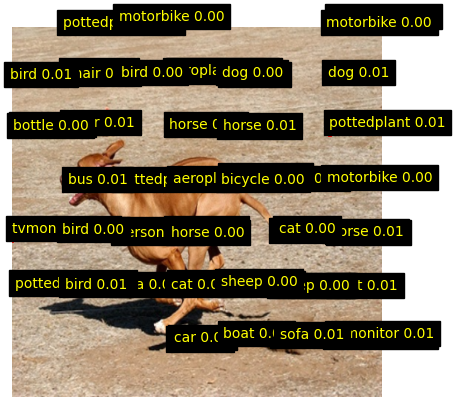

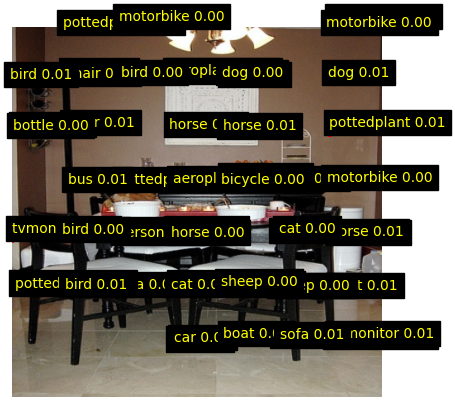

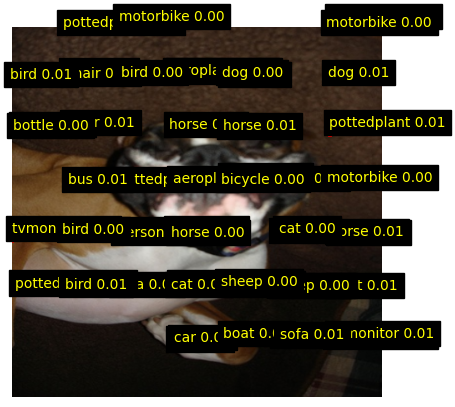

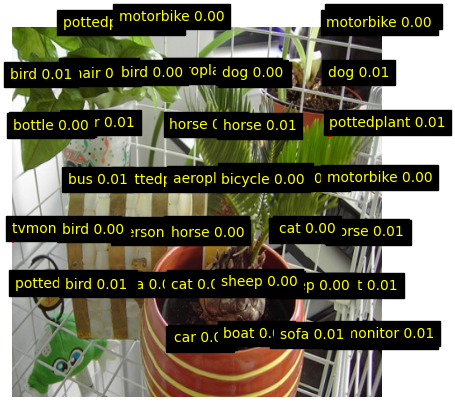

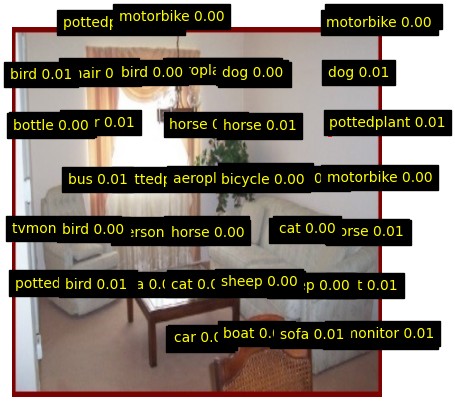

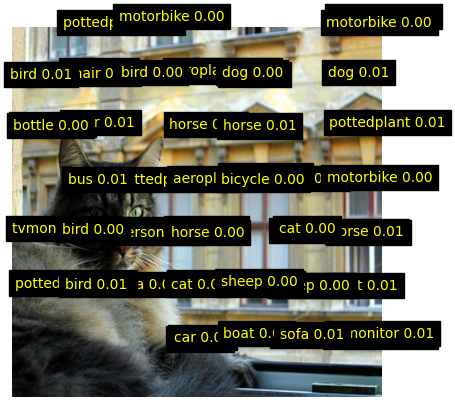

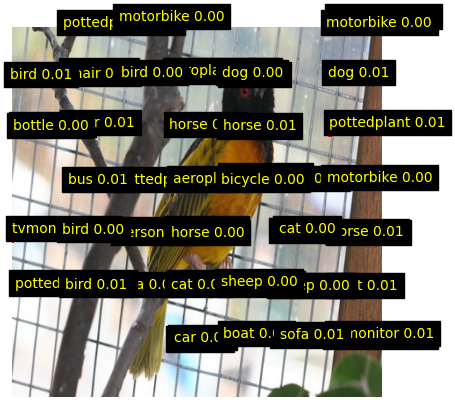

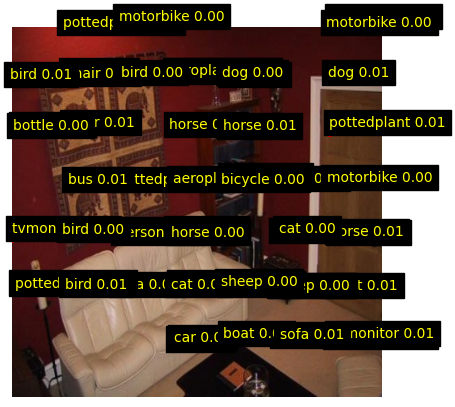

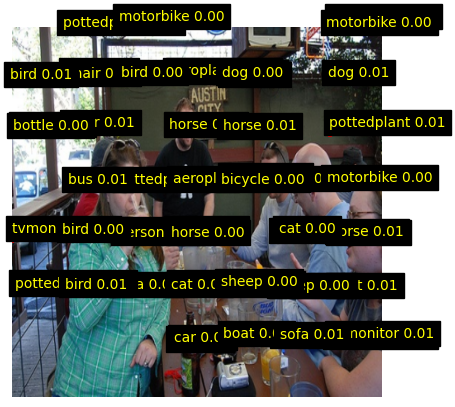

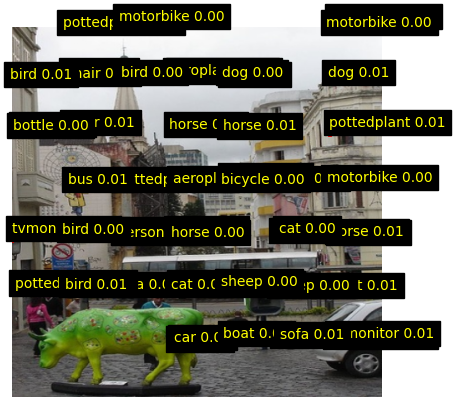

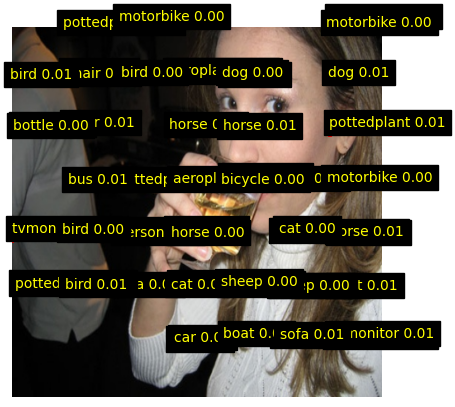

In [64]:
class_names = ["aeroplane","bicycle","bird","boat","bottle","bus","car",
               "cat","chair","cow","diningtable","dog","horse","motorbike",
               "person","pottedplant","sheep","sofa","train","tvmonitor"]

with torch.no_grad():
    for imgs, _ in test_loader:  # you don’t need filenames
        imgs = imgs.to(DEVICE)
        model.to(DEVICE)
        predictions = model(imgs)
        S = 7
        B = 2
        C = 20

        predictions = predictions.view(-1, S, S, B*5 + C) 
        print(predictions.shape)
        for i in range(len(imgs)):
            boxes = decode_yolo_output(predictions[0])
            boxes = apply_nms(boxes)
            plot_boxes(imgs[i], boxes, class_names)
        break
